In [1]:
"""ファブリック

点
"""

import numpy as np
from numpy import linalg as LA
from scipy import integrate
import sympy as sy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from IPython.display import HTML
from math import exp, sin, cos, tan

#import robot_sice_ex.sice_ex as sice_ex

def s(x_dot):
    if x_dot < 0:
        return 1
    else:
        return 0

def sigmoid(x, alpha):
    return 1 / (1 + sy.exp(-alpha * x))


def alpha_He(q_dot, M, pi, xi):
    return (-(q_dot.T @ M @ q_dot + 0.0001)**(-1) * q_dot.T @ (M @ pi + xi))[0,0]

(-1.0995000000000001, 1.089500000000002, -0.05, 1.05)

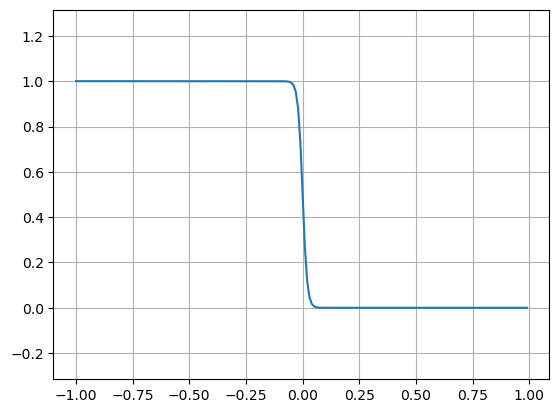

In [4]:
def sigmoid(x, alpha):
    return 1 / (1 + sy.exp(-alpha * (x)))
_x = np.arange(-1, 1, 0.01)
_y = [-sigmoid(i, 100)+1 for i in _x]
plt.plot(_x, _y)
plt.grid()
plt.axis('equal')

(-1.0995000000000001,
 1.089500000000002,
 -0.8375419799643795,
 0.8333101482251417)

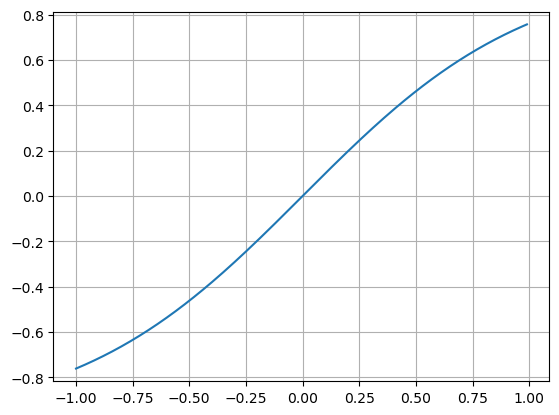

In [5]:

_x = np.arange(-1, 1, 0.01)
_y = [np.tanh(i) for i in _x]
plt.plot(_x, _y)
plt.grid()
plt.axis('equal')

In [2]:
x = sy.MatrixSymbol('x', 2, 1)
x_dot = sy.MatrixSymbol('x_dot', 2, 1)
x_norm = sy.sqrt(x[0,0]**2 + x[1,0]**2)
m_u, m_l, alpha_m, k, alpha_psi = sy.symbols('m_U, m_l, alpha_m, k, alpha_psi')

G = (m_u - m_l) * sy.exp(-(alpha_m * x_norm)**2) * sy.eye(2) + m_u * sy.eye(2)
psi_1 = k * (x_norm + 1/alpha_psi * sy.ln(1 + sy.exp(-2 * alpha_psi * x_norm)))

L = (x_dot.T * G * x_dot)[0,0]
M_ee = sy.Matrix([[sy.diff(L, x_dot[0,0]), sy.diff(L, x_dot[1,0])]]).T.jacobian(x_dot)

xi_ee = sy.Matrix([[sy.diff(L, x_dot[0,0]), sy.diff(L, x_dot[1,0])]]).T.jacobian(x) * x_dot \
    - sy.Matrix([[sy.diff(L, x[0,0])], [sy.diff(L, x[1,0])],])

#M_ee = G
pi_ee = -M_ee * sy.Matrix([
    [sy.diff(psi_1, x[0,0])],
    [sy.diff(psi_1, x[1,0])],
])

func_M_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), M_ee, "numpy")
func_xi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), xi_ee, "numpy")
func_pi_ee = sy.lambdify((x, x_dot, m_u, m_l, alpha_m, k, alpha_psi), pi_ee, "numpy")


# 以下は手計算
def M_ee_(x, m_u, m_l, alpha_m):
    return (m_u - m_l) * exp(-(alpha_m * x_norm)**2) * np.eye(2) + m_u * np.eye(2)

def grad_psi(x, k, alpha_psi):
    x_norm = LA.norm(x)
    return (1 - exp(-2*alpha_psi*x_norm)) / (1 + exp(-2*alpha_psi*x_norm)) * x / x_norm



In [4]:
print(xi_ee)

Matrix([
[2*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[0, 0]*x_dot[0, 0]**2 + 2*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[0, 0]*x_dot[1, 0]**2],
[2*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[1, 0]*x_dot[0, 0]**2 + 2*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[1, 0]*x_dot[1, 0]**2]]) + Matrix([
[-4*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[0, 0]*x_dot[0, 0], -4*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[1, 0]*x_dot[0, 0]],
[-4*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[0, 0]*x_dot[1, 0], -4*alpha_m**2*(m_U - m_l)*exp(-alpha_m**2*(x[0, 0]**2 + x[1, 0]**2))*x[1, 0]*x_dot[1, 0]]])*x_dot


The solver successfully reached the end of the integration interval.


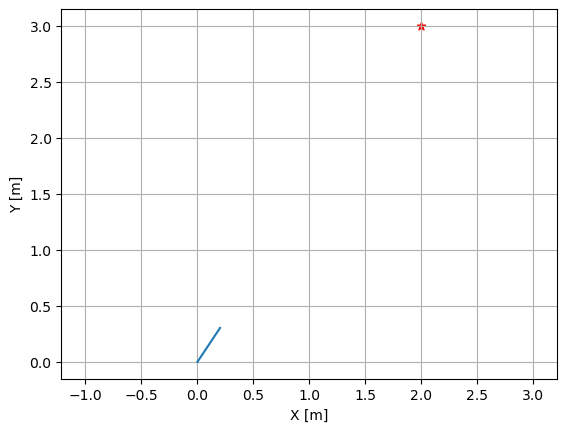

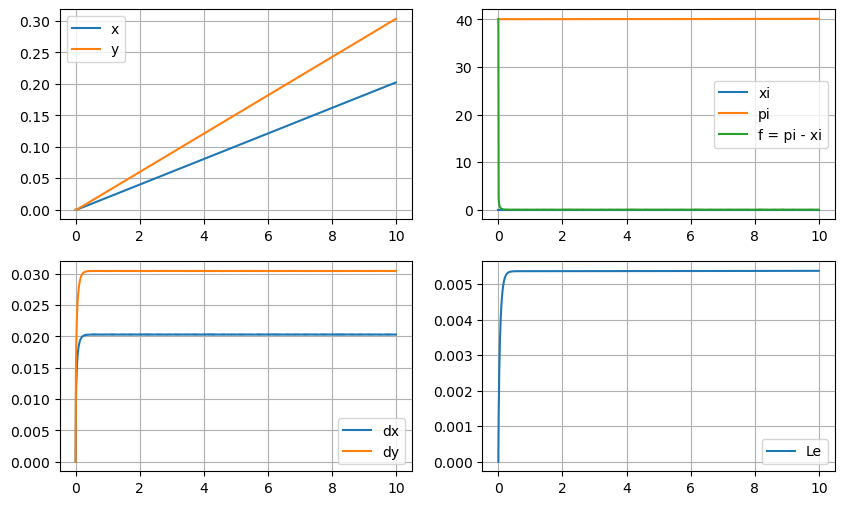

In [35]:
xd = np.array([[2, 3]]).T
m_u = 2
m_l = 0.2
alpha_m = 0.75
k = 10
alpha_psi = 10
damp_k = 20

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    M = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp = damp_k*x_dot
    f = pi - xi - damp + alpha_He(x_dot, M, pi, xi)*x_dot
    a = LA.pinv(M) @ f
    return np.ravel(np.concatenate([x_dot, a]))

X0 = np.array([0, 0, 0, 0.0])
time_interval = 0.01
time_span = 10
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

xi_, pi_, f_ = [], [], []
Le_ = []
for i in range(len(sol.t)):
    x = np.array([[sol.y[0][i], sol.y[1][i]]]).T
    x_dot = np.array([[sol.y[2][i], sol.y[3][i]]]).T
    M = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp = damp_k*x_dot
    f = pi - xi - damp + alpha_He(x_dot, M, pi, xi)*x_dot
    
    Le = (x_dot.T @ M @ x_dot)[0,0]
    Le_.append(Le)
    
    xi_.append(LA.norm(xi))
    pi_.append(LA.norm(pi))
    f_.append(LA.norm(f))

    


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.grid()
ax.axis('equal')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axes[0,0].plot(sol.t, sol.y[0], label="x")
axes[0,0].plot(sol.t, sol.y[1], label="y")
axes[1,0].plot(sol.t, sol.y[2], label="dx")
axes[1,0].plot(sol.t, sol.y[3], label="dy")
axes[0,1].plot(sol.t, xi_, label="xi")
axes[0,1].plot(sol.t, pi_, label="pi")
axes[0,1].plot(sol.t, f_, label="f = pi - xi")
axes[1,1].plot(sol.t, Le_, label="Le")
for ax in axes.ravel():
    ax.legend()
    ax.grid()

----
障害物

In [3]:
# obs avoidance
r, k_b, alpha_b, alpha_sig = sy.symbols('r, k_b, alpha_b, alpha_sig')
x = sy.Symbol('x')
x_dot = sy.Symbol('x_dot')

psi_1b = alpha_b / (2 * x**8)
grad_psi_1b = sy.diff(psi_1b, x)

G = (-sigmoid(x_dot, alpha_sig)+1) * k_b / x**2
#G = k_b / x**2
L = x_dot * G * x_dot

M = sy.diff(L, (x_dot, 2))
xi = sy.diff(sy.diff(L, x_dot), x)*x_dot - sy.diff(L, x)

func_M_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), M, "numpy")
func_xi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), xi, "numpy")
func_pi_obs = sy.lambdify((x, x_dot, k_b, alpha_b, alpha_sig), -M * grad_psi_1b, "numpy")

q = sy.MatrixSymbol('q', 2, 1)
q_o = sy.MatrixSymbol('q_o', 2, 1)
q_dot = sy.MatrixSymbol('q_dot', 2, 1)
q_ = q - q_o
phi = sy.sqrt(q_[0,0]**2 + q_[1,0]**2) / r - 1
s = phi
J = sy.Matrix([[sy.diff(phi, q[0,0]), sy.diff(phi, q[1,0])]])
#s_dot = (1/r * 1/sy.sqrt(q_[0,0]**2 + q_[1,0]**2) * q_.T * q_dot)[0,0]
s_dot = (J * q_dot)[0,0]

func_s = sy.lambdify((q, q_dot, q_o, r), s, "numpy")
func_s_dot = sy.lambdify((q, q_dot, q_o, r), s_dot, "numpy")
func_J = sy.lambdify((q, q_dot, q_o, r), J, "numpy")


In [7]:
xi

2*k_b*x_dot**2*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3 + x_dot*(2*alpha_sig*k_b*x_dot**2*exp(-alpha_sig*x_dot)/(x**3*(1 + exp(-alpha_sig*x_dot))**2) - 4*k_b*x_dot*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3)

(-1.0, 3.0)

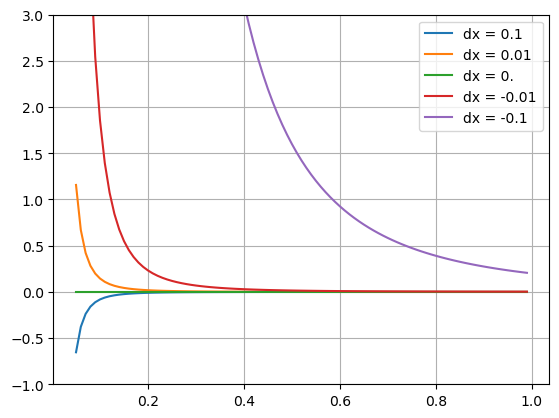

In [28]:
x = np.arange(0.05, 1, 0.01)

y = [-func_xi_obs(xi, 0.1, 10, 1, 100) for xi in x]
plt.plot(x, y, label="dx = 0.1")

y = [-func_xi_obs(xi, 0.01, 10, 1, 100) for xi in x]
plt.plot(x, y, label="dx = 0.01")

y = [-func_xi_obs(xi, 0, 10, 1, 100) for xi in x]
plt.plot(x, y, label="dx = 0.")

y = [-func_xi_obs(xi, -0.01, 10, 1, 100) for xi in x]
plt.plot(x, y, label="dx = -0.01")

y = [-func_xi_obs(xi, -0.1, 10, 1, 100) for xi in x]
plt.plot(x, y, label="dx = -0.1")

plt.grid(); plt.legend()
plt.ylim(-1,3)

<lambdifygenerated-1>:2: RuntimeWarning: overflow encountered in double_scalars
  return k_b*(alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 - 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 + 2 - 2/(1 + exp(-alpha_sig*x_dot)))/x**2
<lambdifygenerated-2>:2: RuntimeWarning: overflow encountered in double_scalars
  return 2*k_b*x_dot**2*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3 + x_dot*(2*alpha_sig*k_b*x_dot**2*exp(-alpha_sig*x_dot)/(x**3*(1 + exp(-alpha_sig*x_dot))**2) - 4*k_b*x_dot*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3)
<lambdifygenerated-3>:2: RuntimeWarning: overflow encountered in double_scalars
  return 4*alpha_b*k_b*(alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 - 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 + 2 - 2/(1 + exp(-alpha_sig*x_dot)))/x**11
<lambdifyg

The solver successfully reached the end of the integration interval.


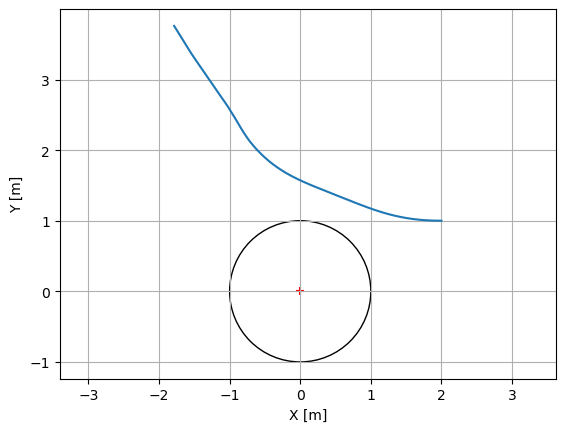

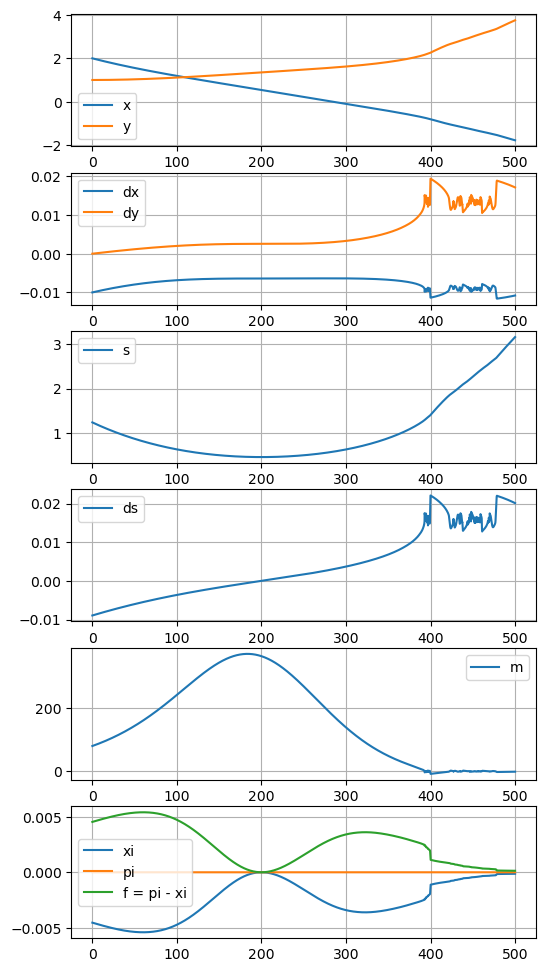

In [32]:
xo = np.array([[0, 0]]).T
r = 1
k_b = 75
alpha_b = 50
alpha_sig = 50

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    
    m = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)*0
    #pi = 0
    #damp = np.zeros((2,1))
    damp = 0. * s_dot
    #print("s_dot = ", s_dot)
    f = pi - xi - damp
    
    pull_M = m * J.T @ J
    pull_f = J.T * f
    
    a = LA.pinv(pull_M) @ pull_f
    #a = np.zeros_like(x)

    # print("M = ", np.ravel(M))
    # print("xi = ", xi.T)
    # print("pi = ", pi.T)
    return np.ravel(np.concatenate([x_dot, a]))


X0 = np.array([2, 1, -0.01, 0.0])
time_interval = 0.01
time_span = 500
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')


s_, s_dot_, m_, xi_, pi_, f_ = [], [], [], [], [], []
for i in range(len(sol.t)):
    x = np.array([[sol.y[0][i], sol.y[1][i]]]).T
    x_dot = np.array([[sol.y[2][i], sol.y[3][i]]]).T
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    m = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)*0
    #pi = 0
    #damp = np.zeros((2,1))
    damp = 0. * s_dot
    #print("s_dot = ", s_dot)
    f = pi - xi - damp
    
    pull_M = m * J.T @ J
    pull_f = J.T * f
    
    a = LA.pinv(pull_M) @ pull_f
    
    s_.append(s)
    s_dot_.append(s_dot)
    m_.append(m)
    xi_.append(xi)
    pi_.append(pi)
    f_.append(f)


fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6, 12))
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
axes[2].plot(sol.t, s_, label="s")
axes[3].plot(sol.t, s_dot_, label="ds")
axes[4].plot(sol.t, m_, label="m")
axes[5].plot(sol.t, xi_, label="xi")
axes[5].plot(sol.t, pi_, label="pi")
axes[5].plot(sol.t, f_, label="f = pi - xi")

for ax in axes.ravel():
    ax.legend()
    ax.grid()

The solver successfully reached the end of the integration interval.


(-0.10405104793742191,
 2.1850720066858598,
 -0.1560765719061329,
 3.27760801002879)

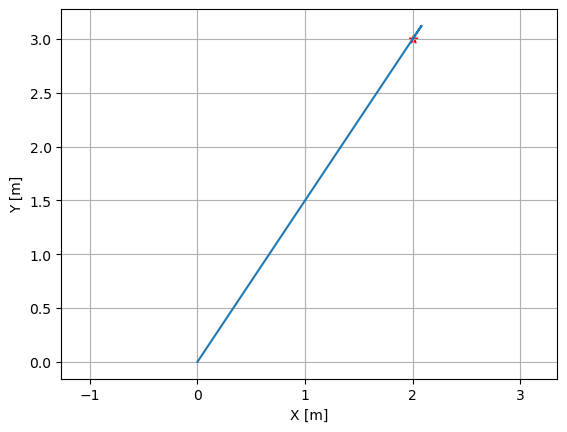

In [11]:
import sys
sys.path.append('.')
import attractor_xi_2d

max_speed = 20.0
gain =  20.0
damp = max_speed / gain
sigma_alpha = 0.5
sigma_gamma = 0.5
wu = 10.0
wl = 0.1
alpha = 0.1
epsilon = 0.05


def rmp_attractor(x, x_dot):
    x_norm = LA.norm(x)
    grad_phi = (1-exp(-2*alpha*x_norm)) / (1+exp(-2*alpha*x_norm)) * x / x_norm
    alpha_x = exp(-x_norm**2 / (2 * sigma_alpha**2))
    gamma_x = exp(-x_norm**2 / (2 * sigma_gamma**2))
    wx = gamma_x*wu + (1 - gamma_x)*wl
    
    M = wx*((1-alpha_x) * grad_phi @ grad_phi.T + (alpha_x+epsilon) * np.eye(2))

    xi = attractor_xi_2d.f(
        x = x,
        x_dot = x_dot,
        sigma_alpha = sigma_alpha,
        sigma_gamma = sigma_gamma,
        w_u = wu,
        w_l = wl,
        alpha = alpha,
        epsilon = epsilon
    )
    pi = M @ (gain * grad_phi)
    d = M @ (damp * x_dot)
    f = M @ (-gain*grad_phi - damp*x_dot) - xi
    
    return M, f, pi, d, xi

def dX(t, X):
    x = X[:2].reshape(-1, 1) - xd
    x_dot = X[2:].reshape(-1, 1)
    
    M, f, _, _, _ = rmp_attractor(x, x_dot)
    a = LA.pinv(M) @ f
    return np.ravel(np.concatenate([x_dot, a]))

X0 = np.array([0, 0, 0, 0.0])
time_interval = 0.01
time_span = 10
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.grid()
ax.axis('equal')


In [12]:
# rmpの障害物（GDS由来のもの）

gain = 5.0
sigma = 1.0
rw = r


def rmp_obs(x, x_dot):
    x_norm = LA.norm(x)
    if rw - x > 0:
        w2 = (rw - x)**2 / x
        w2_dot = (-2*(rw-x)*x + (rw-x)) / x**2
    else:
        w2 = 0
        w2_dot = 0
    
    if x_dot < 0:
        u2 = 1 - exp(-x_dot**2 / (2*sigma**2))
        u2_dot = -exp(x_dot**2 / (2*sigma**2)) * (-x_dot/sigma**3)
    else:
        u2 = 0
        u2_dot = 0
    print("w2 = {0}, w2_dot = {1}, u2 = {2}, u2_dot = {3}".format(w2, w2_dot, u2, u2_dot))
    delta = u2 + 1/2 * x_dot * u2_dot
    xi = 1/2 * u2 * w2_dot * x_dot**2
    grad_phi = gain * w2 * w2_dot

    M = w2 * delta
    f = -grad_phi - xi
    d = 0
    print("xi = {0}, pi = {1}, m = {2}".format(xi, grad_phi, M))
    return M, f, grad_phi, d, xi


def dX(t, X):
    print("\nt = ", t)
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    s = LA.norm(x - xo)
    J = (x-xo).T / s
    s_dot = (J @ x_dot)[0,0]
    #print("s = {0}, s_dot = {1}".format(s, s_dot))
    J_dot = (x_dot.T - (x-xo).T*(1/LA.norm(x-xo)*(x-xo).T @ x_dot)) / LA.norm(x-xo)**2
    M, f, _, _, _ = rmp_obs(s, s_dot)
    
    M = np.minimum(np.maximum(M, - 1e3), 1e3)
    
    pull_M = M * J.T @ J
    pull_f = J.T @ (f - M * J_dot @ x_dot)
    print("pull_M = {0}, pull_f = {1}".format(pull_M, pull_f.T))
    

    
    a = LA.pinv(pull_M) @ pull_f
    return np.ravel(np.concatenate([x_dot, a]))


X0 = np.array([2, 0.5, -0.5, 0.0])
time_interval = 0.01
time_span = 10
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

m_, s_, s_dot_, xi_, pi_, d_,  f_ = [], [], [], [], [], [], []
for i in range(len(sol.t)):
    x = np.array([[sol.y[0][i], sol.y[1][i]]]).T
    x_dot = np.array([[sol.y[2][i], sol.y[3][i]]]).T
    s = LA.norm(x - xo)
    J = (x-xo).T / s
    s_dot = (J @ x_dot)[0,0]
    J_dot = (x_dot.T - (x-xo).T*(1/s*(x-xo).T @ x_dot)) / s**2
    M, f, pi, d, xi = rmp_obs(s, s_dot)
    
    m_.append(M)
    s_.append(s)
    s_dot_.append(s_dot)
    xi_.append(LA.norm(xi))
    pi_.append(LA.norm(pi))
    d_.append(LA.norm(d))
    f_.append(LA.norm(f))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')


fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6, 12))
axes[0].plot(sol.t, sol.y[0], label="x")
axes[0].plot(sol.t, sol.y[1], label="y")
axes[1].plot(sol.t, sol.y[2], label="dx")
axes[1].plot(sol.t, sol.y[3], label="dy")
axes[2].plot(sol.t, s_, label="s")
axes[3].plot(sol.t, s_dot_, label="ds")
axes[4].plot(sol.t, m_, label="m")
axes[5].plot(sol.t, xi_, label="xi")
axes[5].plot(sol.t, pi_, label="pi")
axes[5].plot(sol.t, f_, label="f = pi - xi")

for ax in axes.ravel(): ax.legend(); ax.grid()


t =  0.0
w2 = 0, w2_dot = 0, u2 = 0.11099023459722435, u2_dot = -0.5456309581176525
xi = 0.0, pi = 0.0, m = 0.0
pull_M = [[0. 0.]
 [0. 0.]], pull_f = [[0. 0.]]

t =  0.06921290582660736
w2 = 0, w2_dot = 0, u2 = 0.11077209742965144, u2_dot = -0.5449280230544062
xi = 0.0, pi = 0.0, m = 0.0
pull_M = [[0. 0.]
 [0. 0.]], pull_f = [[0. 0.]]

t =  0.03031736215723618
w2 = 0, w2_dot = 0, u2 = 0.11089598249558008, u2_dot = -0.5453272493212343
xi = 0.0, pi = 0.0, m = 0.0
pull_M = [[0. 0.]
 [0. 0.]], pull_f = [[0. 0.]]

t =  0.04547604323585427
w2 = 0, w2_dot = 0, u2 = 0.11084810278185087, u2_dot = -0.545172958575302
xi = 0.0, pi = 0.0, m = 0.0
pull_M = [[0. 0.]
 [0. 0.]], pull_f = [[0. 0.]]

t =  0.12126944862894472
w2 = 0, w2_dot = 0, u2 = 0.11060088224800624, u2_dot = -0.5443762143758321
xi = 0.0, pi = 0.0, m = 0.0
pull_M = [[0. 0.]
 [0. 0.]], pull_f = [[0. 0.]]

t =  0.13474383180993857
w2 = 0, w2_dot = 0, u2 = 0.11055552258639578, u2_dot = -0.5442300134508229
xi = 0.0, pi = 0.0, m = 0.0
pul

OverflowError: math range error

In [45]:
# シンプルな引力と斥力の組み合わせ

xd = np.array([[-2, 0]]).T
xo = np.array([[0, 0]]).T

m_u = 2
m_l = 0.2
alpha_m = 0.75
k = 150
alpha_psi = 10

r = 1
k_b = 75
alpha_b = 50
alpha_sig = 50

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    
    m_o = func_M_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    xi_o = func_xi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    pi_o = func_pi_obs(s, s_dot, k_b, alpha_b, alpha_sig)
    #pi = 0
    #damp = np.zeros((2,1))
    damp_o = 0. * s_dot
    #print("s_dot = ", s_dot)
    f_o = pi_o - xi_o - damp_o
    
    pull_M = m_o * J.T @ J
    pull_f = J.T * f_o
    
    M_g = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi_g = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi_g = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp_g = 10*x_dot
    f_g = pi_g - xi_g - damp_g

    pull_M += M_g
    pull_f += f_g

    a = LA.pinv(pull_M) @ pull_f

    return np.ravel(np.concatenate([x_dot, a]))


X0 = np.array([2, 0.5, -0.1, 0.0])
time_interval = 0.01
time_span = 100
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')

<lambdifygenerated-13>:2: RuntimeWarning: overflow encountered in double_scalars
  return k_b*(alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 - 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 + 2 - 2/(1 + exp(-alpha_sig*x_dot)))/x**2
<lambdifygenerated-14>:2: RuntimeWarning: overflow encountered in double_scalars
  return 2*k_b*x_dot**2*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3 + x_dot*(2*alpha_sig*k_b*x_dot**2*exp(-alpha_sig*x_dot)/(x**3*(1 + exp(-alpha_sig*x_dot))**2) - 4*k_b*x_dot*(1 - 1/(1 + exp(-alpha_sig*x_dot)))/x**3)
<lambdifygenerated-15>:2: RuntimeWarning: overflow encountered in double_scalars
  return 4*alpha_b*k_b*(alpha_sig**2*x_dot**2*(1 - 2*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot)))*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 - 4*alpha_sig*x_dot*exp(-alpha_sig*x_dot)/(1 + exp(-alpha_sig*x_dot))**2 + 2 - 2/(1 + exp(-alpha_sig*x_dot)))/x**11
<lambdi

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)
ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')

move_point, = ax.plot([], [], marker="o")

def update(i):
    move_point.set_data(sol.y[0][i], sol.y[1][i])

ani2 = anm.FuncAnimation(
    fig = fig,
    func = update,
    frames = range(0, len(sol.t), 10),
    interval=50
)
ani2.save('ani2.gif', writer='pillow')
HTML(ani2.to_jshtml())  # jupyter以外では不要

The solver successfully reached the end of the integration interval.


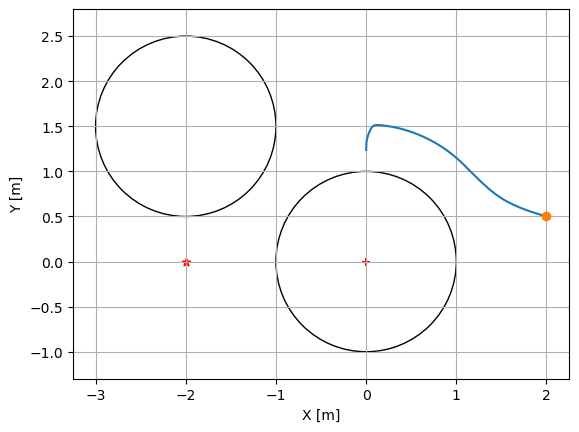

In [51]:
# シンプルな引力と斥力の組み合わせ2

xd = np.array([[-2.0, 0.]]).T
xo = np.array([[0, 0]]).T
xo_2 = np.array([[-2, 1.5]]).T

m_u = 2
m_l = 0.2
alpha_m = 0.75
k = 150
alpha_psi = 10

r = 1
k_b = 29
alpha_b = 1
alpha_sig = 50

def sgn(x_dot):
    if x_dot < 0:
        return 1
    else:
        return 0

def dX(t, X):
    x = X[:2].reshape(-1, 1)
    x_dot = X[2:].reshape(-1, 1)
    
    pull_M = np.zeros((2,2))
    pull_f = np.zeros((2,1))
    
    s = func_s(x, x_dot, xo, r)
    s_dot = func_s_dot(x, x_dot, xo, r)
    J = func_J(x, x_dot, xo, r)
    m_o = sgn(s_dot) * k_b / s**2
    xi_o = -2 * s_dot**2 / x**3 * sgn(s_dot)
    pi_o = -1 * (-4 * alpha_b * s**(-9)) * sgn(s_dot) * s_dot**2 # * m_o
    damp_o = 0. * s_dot
    f_o = pi_o - xi_o - damp_o
    pull_M += m_o * J.T @ J
    pull_f += J.T * f_o

    s = func_s(x, x_dot, xo_2, r)
    s_dot = func_s_dot(x, x_dot, xo_2, r)
    J = func_J(x, x_dot, xo_2, r)
    m_o = sgn(s_dot) * k_b / s**2
    xi_o = -2 * s_dot**2 / x**3 * sgn(s_dot)
    pi_o = -1 * (-4 * alpha_b * s**(-9)) * sgn(s_dot) * s_dot**2 # * m_o
    damp_o = 0. * s_dot
    f_o = pi_o - xi_o - damp_o
    pull_M += m_o * J.T @ J
    pull_f += J.T * f_o


    M_g = func_M_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    xi_g = func_xi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    pi_g = func_pi_ee(x - xd, x_dot, m_u, m_l, alpha_m, k, alpha_psi)
    damp_g = 5*x_dot
    f_g = pi_g - xi_g - damp_g

    pull_M += M_g
    pull_f += f_g

    a = LA.pinv(pull_M) @ pull_f

    return np.ravel(np.concatenate([x_dot, a]))


X0 = np.array([2, 0.5, -0., 0.0])
time_interval = 0.01
time_span = 5
tspan = (0, time_span)
teval = np.arange(0, time_span, time_interval)
sol = integrate.solve_ivp(fun=dX, t_span=tspan, y0=X0, t_eval=teval)
print(sol.message)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(sol.y[0], sol.y[1])
# ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
# ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
# c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
# ax.add_patch(c)
# ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1])
ax.scatter([xo[0,0]], [xo[1,0]], marker="+", color = "r")
ax.scatter([xd[0,0]], [xd[1,0]], marker="*", color = "r")
c = patches.Circle(xy=(xo[0,0], xo[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)

c = patches.Circle(xy=(xo_2[0,0], xo_2[1,0]), radius=r, ec='k', fill=False)
ax.add_patch(c)

ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.grid(); ax.axis('equal')

move_point, = ax.plot([], [], marker="o")

def update(i):
    move_point.set_data(sol.y[0][i], sol.y[1][i])

ani2 = anm.FuncAnimation(
    fig = fig,
    func = update,
    frames = range(0, len(sol.t), 10),
    interval=50
)
ani2.save('ani2.gif', writer='pillow')
HTML(ani2.to_jshtml())  # jupyter以外では不要